In [21]:
!nvidia-smi

Fri Oct 27 10:19:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.84                 Driver Version: 545.84       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P5              14W /  95W |    398MiB /  6144MiB |     74%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [22]:
import torch

print(torch.cuda.is_available())

True


# implement game logic

In [23]:
import torch


class GoGame:
    """
    Go game class.
    This class implements the Go game logic to be used for training the neural network.
    """

    def __init__(self, board_size=19) -> None:
        """
        Initializes the Go game with the given board size.
        Args:
            board_size (int): Size of the Go board (default is 19).
        """
        self.board_size = board_size
        self.board = torch.zeros((board_size, board_size), dtype=torch.float32)

    def place_stone(self, x, y, color) -> None:
        """
        Places a stone of the specified color at the given position (x, y) on the board.
        Args:
            x (float): X-coordinate of the position.
            y (float): Y-coordinate of the position.
            color (float): Color of the stone (1 for black, -1 for white).
        """
        self.board[x][y] = color
        self.remove_dead_stones(x, y, color)

    def has_liberties(self, board, x, y, color, visited, dead_stones):
        """
        Checks if a stone at a given position has liberties.

        Args:
            board (torch.Tensor): Current game board.
            x (int): X-coordinate of the position.
            y (int): Y-coordinate of the position.
            color (int): Color of the stone (1 for black, -1 for white).
            visited (set): Set of visited positions to avoid infinite recursion (default is None).
            no_liberties (set): Set of positions without liberties (default is None).

        Returns:
            tuple: (bool: True if the stone has liberties, False otherwise,
                    set: Updated no_liberties set.)
        """

        # If the position has been visited before, return no liberties
        if (x, y) in visited:
            return False

        # Mark the current position as visited
        visited.add((x, y))

        # Check if the position is out of the board bounds
        if x < 0 or x >= len(board) or y < 0 or y >= len(board[0]):
            return False

        # If the position is empty, it has liberties
        if board[x][y] == 0:
            return True

        # If the stone at the position is not of the given color, it has no liberties
        if board[x][y] != color:
            return False

        # Recursive check for liberties in adjacent positions
        liberties = any(
            self.has_liberties(board, x + dx, y + dy, color, visited, dead_stones
                               ) for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]
        )

        # If the stone has no liberties, add it to the no_liberties set
        if not liberties:
            dead_stones.add((x, y))

        return liberties

    def remove_dead_stones(self, x, y, color) -> None:
        """
        Removes dead stones of the specified color from the board.

        Args:
            x (float): X-coordinate of the position.
            y (float): Y-coordinate of the position.
            color (float): Color of the stone (1 for black, -1 for white).
        """

        # Determine the opponent's color
        opponent_color = -color

        # Create a set to store positions of dead stones
        dead_stones = set()
        visited = set()

        # Iterate through the neighboring positions
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:

            # Check if the neighboring stone has liberties
            self.has_liberties(
                self.board, x + dx, y + dy, opponent_color, visited, dead_stones)

        # Remove dead stones from the board
        for x, y in dead_stones:
            self.board[x][y] = 0

    def get_board(self) -> torch.Tensor:
        """
        Returns the current game board.
        Returns:
            torch.Tensor: Current game board.
        """
        return self.board

    def reset(self) -> None:
        """
        Resets the game board to the initial state.
        """
        self.board = torch.zeros(
            (self.board_size, self.board_size), dtype=torch.float32)


# define dataset for model

In [24]:
import csv
from torch.utils.data import Dataset


class GoDataset(Dataset):
    def __init__(self, path):
        """
        Initializes the GoDataset with the given CSV file path.
        Args:
            path (str): Path to the CSV file containing Go game data.
        """
        super().__init__()
        self.path = path
        self.goGame = GoGame()
        self.char2idx = {c: i for i, c in enumerate('abcdefghijklmnopqrs')}

        # Load data from CSV file
        with open(self.path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            # Read row by row
            self.data = list(reader) # dtype: list[str]
            # Discard the label and player turn information, calculate the max sequence length
            self.max_sequence_length = max([len(row) for row in self.data]) - 2

    def _step(self, step):
        """
        Perform a step in the game based on the given input step.
        Args:
            step (str): A str containing player, x-coordinate, and y-coordinate information.
        """
        current_player = -1 if step[0] == 'B' else 1
        x = self.char2idx[step[2]]
        y = self.char2idx[step[3]]
        self.goGame.place_stone(x, y, current_player)

    def _transform(self, data):
        """
        Transform data from CSV file into a list of padded boards.
        Args:
            data (list): List of steps in the game.
        Returns:
            torch.Tensor: Transformed and padded data.
        """
        transformed_data = []
        for i in range(2, len(data)):
            self._step(data[i])
            transformed_data.append(self.goGame.get_board().clone())

        # Pad the data to the maximum sequence length with a very large negative value
        padded_data = torch.full(
            (self.max_sequence_length, 19, 19), -1e9, dtype=torch.float32)
        for i in range(len(transformed_data)):
            padded_data[i, :, :] = transformed_data[i]

        return padded_data

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get data at the given index.
        Args:
            idx (int): Index of the data sample.
        Returns:
            torch.Tensor: Processed and padded data sample.
        """
        # Get data at the given index
        row = self.data[idx]

        # Transform data into a board
        self.goGame.reset()
        processed_data = self._transform(row)
        return processed_data


goDataset = GoDataset('data/train/dan_train.csv')


# visualize game

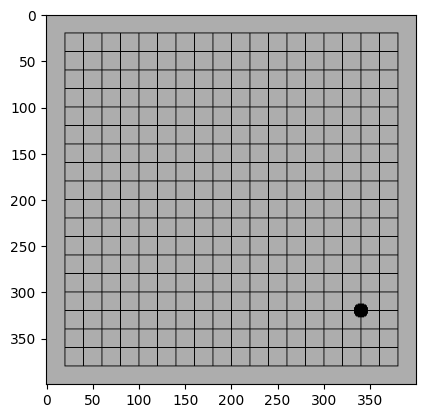

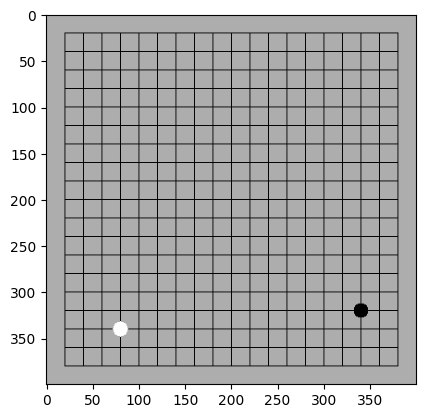

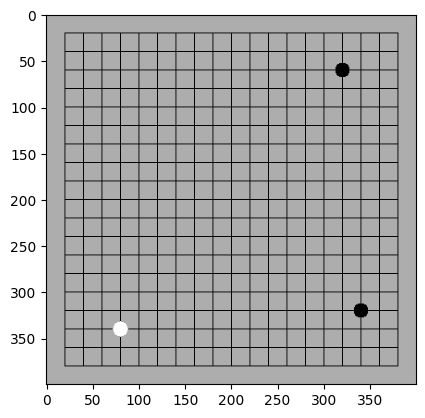

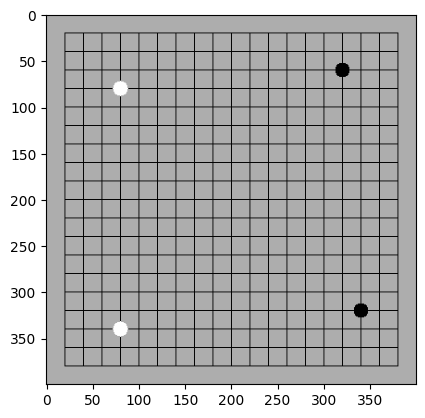

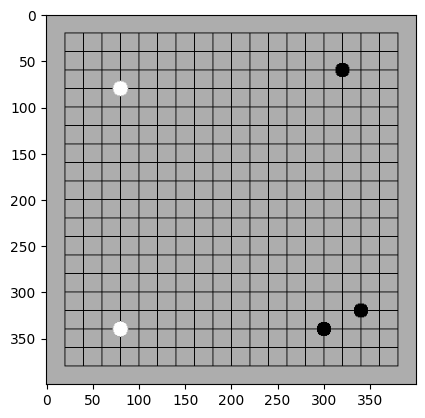

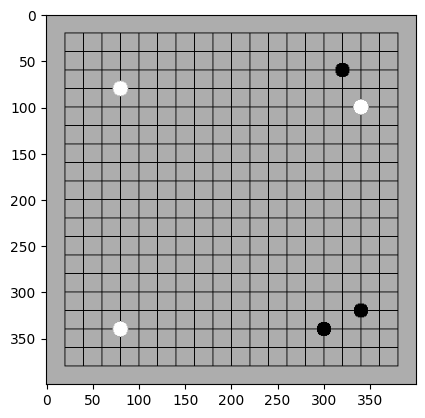

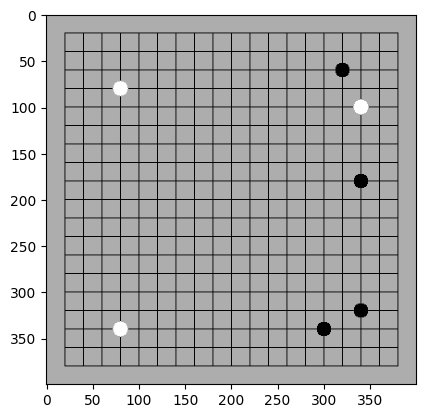

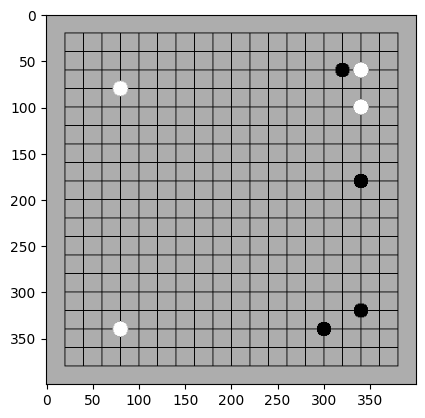

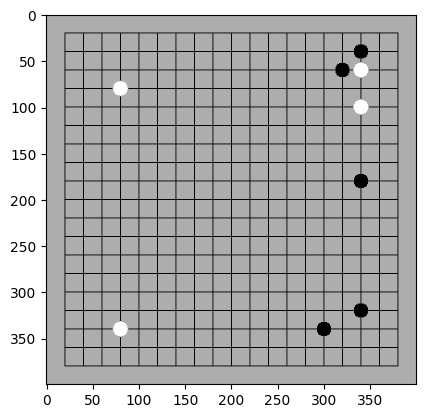

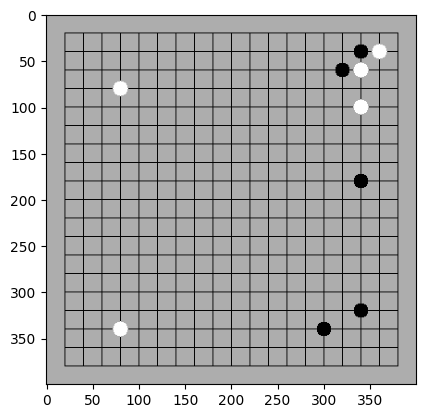

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time


def draw_board(board):
    """
    Draws the Go board with stones based on the provided board configuration.
    Args:
        board (numpy.ndarray): 2D array representing the Go board (-1 for black stones, 1 for white stones, 0 for empty).
    Returns:
        numpy.ndarray: RGB image of the Go board with stones and grid lines.
    """
    # Create an RGB image (3 channels) with a green background
    image = np.ones((20*20, 20*20, 3), dtype=np.uint8) * \
        173  # RGB value for green

    # Draw lines for the board grid
    for i in range(1, 20):
        cv2.line(image, (i * 20, 20), (i * 20, 20*20 - 20),
                 color=(0, 0, 0), thickness=1)
        cv2.line(image, (20, i * 20), (20*20 - 20, i * 20),
                 color=(0, 0, 0), thickness=1)

    black = (0, 0, 0)  # RGB for black
    white = (255, 255, 255)  # RGB for white
    # Draw stones on the board
    for row in range(19):
        for col in range(19):
            if board[row][col] == -1:  # Black stone
                cv2.circle(image, (col * 20 + 20, row * 20 + 20),
                           8, black, -1)  # Draw a filled circle
            elif board[row][col] == 1:  # White stone
                cv2.circle(image, (col * 20 + 20, row * 20 + 20),
                           8, white, -1)  # Draw a filled circle

    return image

boards = goDataset[0]
for i in range(10):
    image = draw_board(boards[i].numpy())
    plt.imshow(image)
    plt.show()
    time.sleep(1)


In [26]:
import cv2


def save_as_video(boards):
    """
    Saves a sequence of Go board states as a video file.
    Args:
        boards (list): List of 2D numpy arrays representing Go board states.
    """
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for video format (MP4)
    # VideoWriter(filename, codec, fps, frameSize)
    video = cv2.VideoWriter('test.mp4', fourcc, 7,
                            (20*20, 20*20))  # VideoWriter object

    # Iterate through the list of board states and save them as frames in the video
    for board in boards:
        image = draw_board(board)  # Convert board state to an RGB image
        video.write(image)  # Write the image as a frame in the video

    # Release the VideoWriter object, finalizing the video creation
    video.release()


boards = goDataset.__getitem__(0)
save_as_video(boards)


# PredEncoder

In [27]:
import torch
import torch.nn as nn


class PredEncoder(nn.Module):
    """
    PredNet encoder module.

    Args:
        input_dim (int): input dimension.
        num_channels (int): number of depthwise convolution layer input channels.
        depthwise_kernel_size (int): kernel size of depthwise convolution layer.
        dropout (float, optional): dropout probability. (Default: 0.0)
        bias (bool, optional): indicates whether to add bias term to each convolution layer. (Default: ``False``)
        use_group_norm (bool, optional): use GroupNorm rather than BatchNorm. (Default: ``False``)
    """

    def __init__(
        self,
        input_dim: int,
        num_channels: int,
        depthwise_kernel_size: int,
        dropout: float = 0.0,
        bias: bool = False,
        use_group_norm: bool = False,
    ) -> None:
        super().__init__()
        if (depthwise_kernel_size - 1) % 2 != 0:
            raise ValueError(
                "depthwise_kernel_size must be odd to achieve 'SAME' padding.")

        # Layer normalization for input
        self.layer_norm = nn.LayerNorm(input_dim)

        # Sequential layers: 1x1 Conv, GLU, Depthwise Conv, Normalization, Activation, 1x1 Conv, Dropout
        self.sequential = nn.Sequential(
            nn.Conv1d(
                input_dim,
                2 * num_channels,
                1,
                stride=1,
                padding=0,
                bias=bias,
            ),
            nn.GLU(dim=1),
            nn.Conv1d(
                num_channels,
                num_channels,
                depthwise_kernel_size,
                stride=1,
                padding=(depthwise_kernel_size - 1) // 2,
                groups=num_channels,
                bias=bias,
            ),
            nn.GroupNorm(num_groups=1, num_channels=num_channels)
            if use_group_norm
            else nn.BatchNorm1d(num_channels),
            nn.SiLU(),  # SiLU activation function (Sigmoid Linear Unit)
            nn.Conv1d(
                num_channels,
                input_dim,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=bias,
            ),
            nn.Dropout(dropout),
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Conformer convolution module.

        Args:
            input (torch.Tensor): Input tensor with shape `(B, D)`.
            B: Batch size, D: Input dimension

        Returns:
            torch.Tensor: Output tensor with shape `(B, D)`.
        """
        # input: (B, D) -> (B, 1, D)
        x = input.unsqueeze(1)
        x = self.layer_norm(x)

        # x: (B, 1, D) -> (B, D, 1)
        x = x.transpose(1, 2)
        x = self.sequential(x)

        return x.squeeze(2)


# conformer

In [28]:
import torch
import torch.nn as nn


class ConvModule(nn.Module):
    """
    Conformer convolution module.

    Args:
        input_dim (int): input dimension.
        num_channels (int): number of depthwise convolution layer input channels.
        depthwise_kernel_size (int): kernel size of depthwise convolution layer.
        dropout (float, optional): dropout probability. (Default: 0.0)
        bias (bool, optional): indicates whether to add bias term to each convolution layer. (Default: ``False``)
        use_group_norm (bool, optional): use GroupNorm rather than BatchNorm. (Default: ``False``)
    """

    def __init__(
        self,
        input_dim: int,
        num_channels: int,
        depthwise_kernel_size: int,
        dropout: float = 0.0,
        bias: bool = False,
        use_group_norm: bool = False,
    ) -> None:
        super().__init__()
        if (depthwise_kernel_size - 1) % 2 != 0:
            raise ValueError(
                "depthwise_kernel_size must be odd to achieve 'SAME' padding.")

        # Layer normalization for input
        self.layer_norm = nn.LayerNorm(input_dim)

        # Sequential layers: 1x1 Conv, GLU, Depthwise Conv, Normalization, Activation, 1x1 Conv, Dropout
        self.sequential = nn.Sequential(
            nn.Conv1d(
                input_dim,
                2 * num_channels,
                1,
                stride=1,
                padding=0,
                bias=bias,
            ),
            nn.GLU(dim=1),
            nn.Conv1d(
                num_channels,
                num_channels,
                depthwise_kernel_size,
                stride=1,
                padding=(depthwise_kernel_size - 1) // 2,
                groups=num_channels,
                bias=bias,
            ),
            nn.GroupNorm(num_groups=1, num_channels=num_channels)
            if use_group_norm
            else nn.BatchNorm1d(num_channels),
            nn.SiLU(),  # SiLU activation function (Sigmoid Linear Unit)
            nn.Conv1d(
                num_channels,
                input_dim,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=bias,
            ),
            nn.Dropout(dropout),
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Conformer convolution module.

        Args:
            input (torch.Tensor): Input tensor with shape `(B, T, D)`.
            B: Batch size, T: Sequence length, D: Input dimension

        Returns:
            torch.Tensor: Output tensor with shape `(B, T, D)`.
        """
        x = self.layer_norm(input)
        # Transpose to shape `(B, D, T)` for 1D convolutions
        x = x.transpose(1, 2)
        x = self.sequential(x)  # Apply sequential layers
        return x.transpose(1, 2)  # Transpose back to shape `(B, T, D)`


class FeedForwardModule(nn.Module):
    """
    Feedforward module with Layer Normalization, Linear layers, SiLU activation, and Dropout.

    Args:
        input_dim (int): Input dimension.
        hidden_dim (int): Hidden layer dimension.
        dropout (float, optional): Dropout probability. (Default: 0.1)
    """

    def __init__(self, input_dim, hidden_dim, dropout=0.1):
        super(FeedForwardModule, self).__init__()
        self.module = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # SiLU activation function (Sigmoid Linear Unit)
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        Forward pass of the FeedForwardModule.

        Args:
            x (torch.Tensor): Input tensor with shape `(B, T, D)`.

        Returns:
            torch.Tensor: Output tensor with the same shape as the input tensor.
        """
        return self.module(x)


class ConformerBlock(nn.Module):
    """
    Conformer layer that constitutes Conformer.

    Args:
        input_dim (int): input dimension.
        ffn_dim (int): hidden layer dimension of the feedforward network.
        num_attention_heads (int): number of attention heads.
        depthwise_conv_kernel_size (int): kernel size of the depthwise convolution layer.
        dropout (float, optional): dropout probability. (Default: 0.1)
        use_group_norm (bool, optional): use ``GroupNorm`` rather than ``BatchNorm1d``
            in the convolution module. (Default: ``False``)
        convolution_first (bool, optional): apply the convolution module ahead of
            the attention module. (Default: ``False``)
    """

    def __init__(
            self,
            input_dim,
            ffn_dim,
            num_attention_heads,
            depthwise_conv_kernel_size,
            dropout=0.1,
            use_group_norm=False,
            convolution_first=False,
    ):
        super().__init__()
        self.ffn1 = FeedForwardModule(input_dim, ffn_dim, dropout)
        self.ffn2 = FeedForwardModule(input_dim, ffn_dim, dropout)
        self.conv = ConvModule(
            input_dim,
            input_dim,
            depthwise_conv_kernel_size,
            dropout,
            use_group_norm=use_group_norm,
        )
        self.self_attn = nn.MultiheadAttention(
            input_dim, num_attention_heads, dropout=dropout
        )
        self.self_attn_dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(input_dim)
        self.convolution_first = convolution_first

    def apply_conv(self, x):
        """
        Apply the convolution module.

        Args:
            x (torch.Tensor): Input tensor with shape `(T, B, D)`.

        Returns:
            torch.Tensor: Output tensor after applying the convolution module.
        """
        residual = x
        # Transpose to shape `(B, T, D)` for 1D convolutions
        x = x.transpose(0, 1)
        x = self.conv(x)
        x = x.transpose(0, 1)  # Transpose back to shape `(T, B, D)`
        x = x + residual
        return x

    def forward(self, x):
        """
        Forward pass of the ConformerBlock.

        Args:
            x (torch.Tensor): Input tensor with shape `(T, B, D)`.

        Returns:
            torch.Tensor: Output tensor with the same shape as the input tensor.
        """
        residual = x
        x = self.ffn1(x)  # First feedforward module
        x = 0.5 * x + residual  # Residual connection and scaling

        if self.convolution_first:
            x = self.apply_conv(x)  # Apply convolution module if specified

        residual = x
        x = self.layer_norm(x)  # Layer normalization
        x, _ = self.self_attn(x, x, x)  # Multihead self-attention
        x = self.self_attn_dropout(x)
        x = x + residual  # Residual connection

        if not self.convolution_first:
            x = self.apply_conv(x)  # Apply convolution module if specified

        residual = x
        x = self.ffn2(x)  # Second feedforward module
        x = 0.5 * x + residual  # Residual connection and scaling
        x = self.layer_norm(x)  # Final layer normalization
        return x


class Conformer(nn.Module):
    """
    Args:
        input_dim (int): input dimension.
        num_heads (int): number of attention heads in each Conformer layer.
        ffn_dim (int): hidden layer dimension of feedforward networks.
        num_layers (int): number of Conformer layers to instantiate.
        depthwise_conv_kernel_size (int): kernel size of each Conformer layer's depthwise convolution layer.
        dropout (float, optional): dropout probability. (Default: 0.1)
        use_group_norm (bool, optional): use ``GroupNorm`` rather than ``BatchNorm1d``
            in the convolution module. (Default: ``False``)
        convolution_first (bool, optional): apply the convolution module ahead of
            the attention module. (Default: ``False``)
    """

    def __init__(
            self,
            input_dim,
            num_heads,
            ffn_dim,
            num_layers,
            depthwise_conv_kernel_size,
            dropout=0.1,
            use_group_norm=False,
            convolution_first=False,
    ):
        super().__init__()

        # Instantiate Conformer blocks
        self.conformer_blocks = nn.ModuleList(
            [
                ConformerBlock(
                    input_dim,
                    ffn_dim,
                    num_heads,
                    depthwise_conv_kernel_size,
                    dropout,
                    use_group_norm,
                    convolution_first,
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        """
        Forward pass of the Generator (Conformer model).

        Args:
            x (torch.Tensor): input with shape `(B, T, input_dim)`.

        Returns:
            torch.Tensor: output with shape `(B, T, input_dim)`.
        """
        batch_size, seq_length, _, _ = x.shape
        x = x.view(batch_size, seq_length, -1)  # Flatten input tensor

        x = x.transpose(0, 1)  # Transpose to shape `(T, B, input_dim)`

        # Pass input through Conformer blocks
        for layer in self.conformer_blocks:
            x = layer(x)

        x = x.transpose(0, 1)  # Transpose back to shape `(B, T, input_dim)`

        return x





# generator

In [29]:
class Generator(nn.Module):
    """
    Model: Conformer

    Args:
        input_dim (int): input dimension.
        output_dim (int): output dimension.
        num_heads (int): number of attention heads in each Conformer layer.
        ffn_dim (int): hidden layer dimension of feedforward networks.
        num_layers (int): number of Conformer layers to instantiate.
        depthwise_conv_kernel_size (int): kernel size of each Conformer layer's depthwise convolution layer.
        dropout (float, optional): dropout probability. (Default: 0.1)
        use_group_norm (bool, optional): use ``GroupNorm`` rather than ``BatchNorm1d``
            in the convolution module. (Default: ``False``)
        convolution_first (bool, optional): apply the convolution module ahead of
            the attention module. (Default: ``False``)
    """

    def __init__(
            self,
            input_dim,
            output_dim,
            num_heads,
            ffn_dim,
            num_layers,
            depthwise_conv_kernel_size,
            dropout=0.1,
            use_group_norm=False,
            convolution_first=False,
    ):
        super(Generator, self).__init__()

        # Instantiate the Conformer module
        self.conformer = Conformer(
            input_dim,
            num_heads,
            ffn_dim,
            num_layers,
            depthwise_conv_kernel_size,
            dropout,
            use_group_norm,
            convolution_first,
        )
        self.output_dim = output_dim

    def forward(self, x):
        """
        Forward pass of the Generator (Conformer model).

        Args:
            x (torch.Tensor): input with shape `(B, T, input_dim)`.

        Returns:
            torch.Tensor: output with shape `(B, output_dim)`.
        """
        input_copy = torch.clone(x)

        # Pass the input through the Conformer layers
        conformer_output = self.conformer(x)

        # Reshape the output for the linear layer
        B, T, D = conformer_output.shape
        reshaped_output = conformer_output.reshape(B, T * D)

        # Apply linear transformation
        linear_output = nn.Linear(
            reshaped_output.shape[1], self.output_dim)(reshaped_output)
        # Apply log softmax activation
        output = nn.LogSoftmax(dim=1)(linear_output)
        # nn.crossEntropyLoss() expects the output to be of shape (B, output_dim)

        return output, input_copy


height, width = 19, 19

gen = Generator(
    input_dim=height * width,
    output_dim=height * width,
    num_heads=1,
    ffn_dim=8,
    num_layers=6,
    depthwise_conv_kernel_size=3,
    dropout=0.1,
    use_group_norm=False,
    convolution_first=False,
)


# discriminator

In [30]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    """
    Model: Conformer, PredEncoder

    Args:
        input_dim (int): input dimension for Conformer.
        height (int): height of the input for PredEncoder.
        width (int): width of the input for PredEncoder.
        num_heads (int): number of attention heads in each Conformer layer.
        ffn_dim (int): hidden layer dimension of feedforward networks in Conformer.
        num_layers (int): number of Conformer layers to instantiate.
        depthwise_conv_kernel_size (int): kernel size of each Conformer layer's depthwise convolution layer.
        dropout (float, optional): dropout probability. (Default: 0.1)
        use_group_norm (bool, optional): use ``GroupNorm`` rather than ``BatchNorm1d``
            in the convolution module. (Default: ``False``)
        convolution_first (bool, optional): apply the convolution module ahead of
            the attention module. (Default: ``False``)
    """

    def __init__(
            self,
            input_dim,
            height,
            width,
            num_heads,
            ffn_dim,
            num_layers,
            depthwise_conv_kernel_size,
            dropout=0.1,
            use_group_norm=False,
            convolution_first=False,
    ):
        super(Discriminator, self).__init__()

        # Instantiate the Generator (Conformer) module
        self.generator = Generator(
            input_dim,
            height * width,
            num_heads,
            ffn_dim,
            num_layers,
            depthwise_conv_kernel_size,
            dropout,
            use_group_norm,
            convolution_first,
        )

        # Instantiate the PredEncoder module
        self.pred_encoder = PredEncoder(
            input_dim=height * width,
            num_channels=height * width,
            depthwise_kernel_size=3,
            bias=False,
            use_group_norm=False,
        )

        # Linear layers for final classification
        self.linear = nn.Sequential(
            # Concatenate Conformer output and PredEncoder output
            nn.Linear(2 * (height * width), height),
            nn.BatchNorm1d(height),
            nn.SiLU(),
            nn.Linear(height, 2)  # Output one-hut vector for binary classification
        )

    def forward(self, x, y):
        """
        Forward pass of the Discriminator.

        Args:
            x (torch.Tensor): input with shape `(B, T, input_dim)` (for Conformer).
            y (torch.Tensor): input with shape `(B, height * width)` (for PredEncoder).

        Returns:
            torch.Tensor: output with shape `(B, 2)` (binary classification result).
        """
        # Pass the input through the Conformer (Generator) layers
        x, _ = self.generator(x)
        # Pass the input through the PredEncoder
        y = self.pred_encoder(y)    # G(x) or ground truth y or ground truth with wrong cond

        # Concatenate Conformer output and PredEncoder output
        x = torch.cat((x, y), dim=1)

        # Apply linear transformation for final classification
        x = self.linear(x)

        return x


dis = Discriminator(
    input_dim=height * width,
    height=height,
    width=width,
    num_heads=1,
    ffn_dim=8,
    num_layers=6,
    depthwise_conv_kernel_size=3,
    dropout=0.1,
    use_group_norm=False,
    convolution_first=False,
)


# test

In [31]:
from torch.utils.data import DataLoader

batch_size = 2

test_loader = DataLoader(goDataset, batch_size=batch_size, shuffle=True)

for idx, batch in enumerate(test_loader):
    print(idx)
    print(batch.shape)
    output, input_copy = gen(batch)
    print(output.shape)
    output = dis(input_copy, output)
    print(output.shape)
    if idx == 2:
        break



0
torch.Size([2, 380, 19, 19])
torch.Size([2, 361])
torch.Size([2, 2])
1
torch.Size([2, 380, 19, 19])
torch.Size([2, 361])
torch.Size([2, 2])
2
torch.Size([2, 380, 19, 19])
torch.Size([2, 361])
torch.Size([2, 2])
